<a href="https://colab.research.google.com/github/Muhaiminul8473/Bengali-food-review-classification/blob/main/LSTM_for_bengali_food_review_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import tensorflow as tf

tf.__version__


'2.5.0'

In [2]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding
from keras.optimizers import RMSprop,Adam,SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [3]:
import pandas as pd
df=pd.read_excel("/content/gdrive/My Drive/Soultimes_works/SoulTimes2.xlsx")
df.head()

,Reviews,Rating
0,বনশ্রী তে বেস্ট কাচ্চি খাওয়া এখন পর্যন্ত The ...,Best
1,মিররের এরাবিয়ান রাইস ( মান্দি )না খেলে জীবন ই...,Best
2,২২০ টাকা দিয়ে হেব্বি একটা খাবার খেলাম Bela Bit...,Best
3,"৩০০ টাকায় পাস্তা পেটেরপান খেতে চলে গেলাম, দ্যা...",Best
4,গিয়েছিলাম খেতে #Steakout এ অর্ডার করেছিলাম : C...,Best


In [4]:
dfbest = df[df["Rating"]=='Best']

In [5]:
dfgood = df[df["Rating"]=='Good']

In [6]:
dfbad = df[df["Rating"]=='Bad']

In [7]:
df = pd.concat([dfbest,dfgood,dfbad],ignore_index=False)

In [8]:
df

,Reviews,Rating
0,বনশ্রী তে বেস্ট কাচ্চি খাওয়া এখন পর্যন্ত The ...,Best
1,মিররের এরাবিয়ান রাইস ( মান্দি )না খেলে জীবন ই...,Best
2,২২০ টাকা দিয়ে হেব্বি একটা খাবার খেলাম Bela Bit...,Best
3,"৩০০ টাকায় পাস্তা পেটেরপান খেতে চলে গেলাম, দ্যা...",Best
4,গিয়েছিলাম খেতে #Steakout এ অর্ডার করেছিলাম : C...,Best
...,...,...
994,#নেগেটিভ_রিভিউ। হাজীর বিরিয়ানী নাজিরাবাজার। ১৬...,Bad
995,আজকের খাবার অভিগ্যতা: ফায়ারফ্লাইস (ধানমন্ডি ২৭...,Bad
996,#নেগেটিভ_রিভিউ। খুব বেশি কিছু বলার নাই শুধু মা...,Bad
997,"জঘন্য অভিজ্ঞতা: ইন্ডিয়ান স্পাইসি, বসুন্ধরা সিট...",Bad


In [9]:
df['Rating'].value_counts()

Good    333
Bad     330
Best    327
Name: Rating, dtype: int64

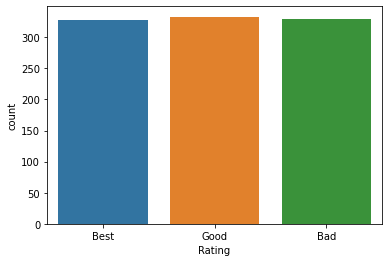

In [10]:
import seaborn as sns

sns.countplot(x='Rating', data=df)
#plt.savefig('/content/data.png')

In [11]:
def count_words(count_dict, text):
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

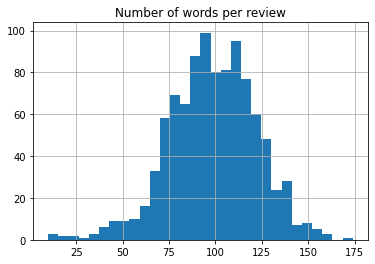

In [12]:
import matplotlib.pyplot as plt
text_word_count = []

# populate the lists with sentence lengths
for i in df['Reviews']:
      text_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Number of words per review':text_word_count})
length_df.hist(bins = 30)
plt.show()

In [13]:
df.columns

Index(['Reviews', 'Rating'], dtype='object')

In [14]:
df.shape

(990, 2)

In [15]:
import string 
def remove_punc(s):
    table = str.maketrans({key: None for key in string.punctuation})
    return s.translate(table)
x = df['Reviews'].apply(remove_punc)
x.shape

(990,)

In [16]:
x

0      বনশ্রী তে বেস্ট কাচ্চি খাওয়া এখন পর্যন্ত The ...
1      মিররের  এরাবিয়ান রাইস  মান্দি না খেলে জীবন ই  ...
2      ২২০ টাকা দিয়ে হেব্বি একটা খাবার খেলাম Bela Bit...
3      ৩০০ টাকায় পাস্তা পেটেরপান খেতে চলে গেলাম দ্যা ...
4      গিয়েছিলাম খেতে Steakout এ অর্ডার করেছিলাম  Che...
                             ...                        
994    নেগেটিভরিভিউ। হাজীর বিরিয়ানী নাজিরাবাজার। ১৬০ ...
995    আজকের খাবার অভিগ্যতা ফায়ারফ্লাইস ধানমন্ডি ২৭। ...
996    নেগেটিভরিভিউ। খুব বেশি কিছু বলার নাই শুধু মানু...
997    জঘন্য অভিজ্ঞতা ইন্ডিয়ান স্পাইসি বসুন্ধরা সিটি ...
998    শপ টেস্টি ট্রিট। টেস্ট জঘন্য মাইনাসে রেটিং দিল...
Name: Reviews, Length: 990, dtype: object

In [17]:
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
df['Rating'] =l.fit_transform(df['Rating'])
df

,Reviews,Rating
0,বনশ্রী তে বেস্ট কাচ্চি খাওয়া এখন পর্যন্ত The ...,1
1,মিররের এরাবিয়ান রাইস ( মান্দি )না খেলে জীবন ই...,1
2,২২০ টাকা দিয়ে হেব্বি একটা খাবার খেলাম Bela Bit...,1
3,"৩০০ টাকায় পাস্তা পেটেরপান খেতে চলে গেলাম, দ্যা...",1
4,গিয়েছিলাম খেতে #Steakout এ অর্ডার করেছিলাম : C...,1
...,...,...
994,#নেগেটিভ_রিভিউ। হাজীর বিরিয়ানী নাজিরাবাজার। ১৬...,0
995,আজকের খাবার অভিগ্যতা: ফায়ারফ্লাইস (ধানমন্ডি ২৭...,0
996,#নেগেটিভ_রিভিউ। খুব বেশি কিছু বলার নাই শুধু মা...,0
997,"জঘন্য অভিজ্ঞতা: ইন্ডিয়ান স্পাইসি, বসুন্ধরা সিট...",0


In [18]:
y=to_categorical(df['Rating'])
y.shape

(990, 3)

In [19]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.2,random_state=2222)

In [20]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_test.shape

(198,)

In [21]:
max_words = 300
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [22]:

def RNN():
  inputs = Input(shape=[max_len,])
  layer = Embedding(max_words,150,input_length=max_len,)(inputs)
  layer = Activation('relu')(layer)
  layer = Dropout(.3)(layer)
  layer = LSTM(128)(layer)
  layer = Dense(128,activation='relu')(layer)
  layer = Dropout(.3)(layer)
  layer = Dense(3,activation='softmax')(layer)
  
  model = Model(inputs=inputs,outputs=layer)
  return model

In [23]:
model = RNN()
#model.summary()
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=.0001),metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


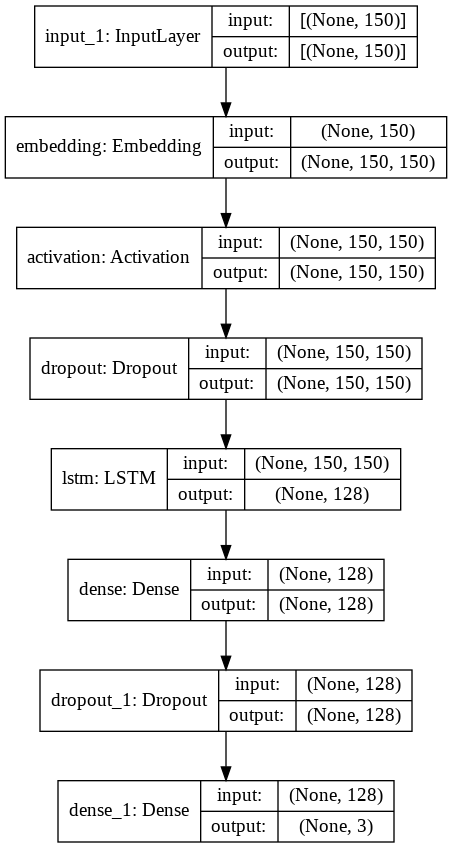

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,to_file='model.png')

In [29]:
history = model.fit(sequences_matrix, y_train, epochs=1000, batch_size=128,validation_split=.2)

Epoch 1/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.0095 - acc: 0.9984 - val_loss: 2.1364 - val_acc: 0.6730
Epoch 2/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 2.3039 - val_acc: 0.6667
Epoch 3/1000
5/5 [==============================] - 0s 29ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 2.3669 - val_acc: 0.6541
Epoch 4/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 2.3178 - val_acc: 0.6792
Epoch 5/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 2.2744 - val_acc: 0.6855
Epoch 6/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 2.2947 - val_acc: 0.6918
Epoch 7/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 2.2727 - val_acc: 0.6855
Epoch 8/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.0055 - a

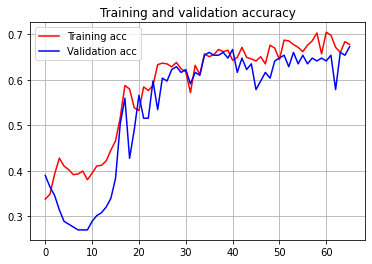

In [25]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot( acc, 'r', label='Training acc')
plt.plot( val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.legend()
#plt.savefig('/content/accuracy.png')

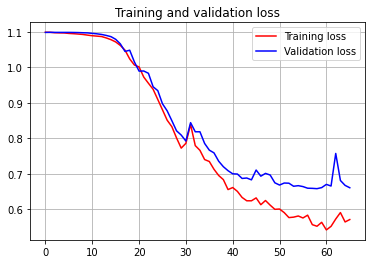

In [26]:
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.legend()
#plt.savefig('/content/loss.png')

In [30]:
test_sequences = tok.texts_to_sequences(x_test)

test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print("Test set loss :{:0.3f}\n accuracy : {:0.3f}".format(accr[0],accr[1]))

7/7 [==============================] - 0s 8ms/step - loss: 2.6203 - acc: 0.7323
Test set loss :2.620
 accuracy : 0.732


In [31]:
from sklearn.metrics import classification_report,confusion_matrix

predicted=model.predict(test_sequences_matrix)
print(confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1)))
print(classification_report(y_test,predicted>.55))

[[58  6  3]
 [ 6 46 19]
 [ 5 14 41]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        67
           1       0.70      0.65      0.67        71
           2       0.65      0.68      0.67        60

   micro avg       0.73      0.73      0.73       198
   macro avg       0.73      0.73      0.73       198
weighted avg       0.73      0.73      0.73       198
 samples avg       0.73      0.73      0.73       198



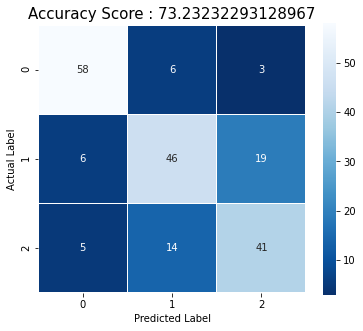

In [32]:
cm = confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1))
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='',linewidth=.15,square=True,cmap='Blues_r');
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
#plt.savefig('/content/matrix.png')
all_sample_title = 'Accuracy Score : {0}'.format(accr[1]*100)
plt.title(all_sample_title,size=15);

In [ ]:

tes = ['লিভারপুলের মতো ভুল করবে না সিটি',
       'করোনা মোকাবিলায় যে কৌশলে এগিয়ে দরিদ্র এই দেশগুলো',
       'করোনাবশের চেষ্টায় জাপানের গবেষকেরা',
       'তথ্যপ্রযুক্তি খাতে বড় বিপর্যয়ের আশঙ্কা',
       'ভিডিও কনফারেন্সের সুবিধা নিয়ে এল']
t = tok.texts_to_sequences(tes)
t = sequence.pad_sequences(t,maxlen=max_len)
preds = model.predict(t)
print(preds)